In [1]:
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import random
import torch

from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.backends import cudnn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.metrics import accuracy_score
from scipy.stats import sem
from sklearn.metrics import confusion_matrix

from collections import defaultdict

import albumentations as A

In [2]:
test_images_path = 'test_dataset/'

def load_images_from_folder(folder): 
    images = []
    for filename in os.listdir(folder): # читаю все предобратанные картинки с фигурами
        print(os.path.join(folder,filename))
        images.append(os.path.join(folder,filename))
    return images

images = load_images_from_folder(test_images_path)

test_dataset/9.jpg
test_dataset/12.png
test_dataset/13.png
test_dataset/11.png
test_dataset/10.jpg
test_dataset/8.jpeg
test_dataset/4.png
test_dataset/5.png
test_dataset/7.jpg
test_dataset/6.png
test_dataset/2.png
test_dataset/3.png
test_dataset/1.png
test_dataset/14


In [3]:
genderModel = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes= 2)

genderModel.load_state_dict(torch.load('models/gender_model0.pth'))
genderModel.eval()

ageModel = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes= 4)

ageModel.load_state_dict(torch.load('models/age_model1.pth'))
ageModel.eval()

trans = transforms.Compose([
    np.float32,
    transforms.ToTensor(),
    fixed_image_standardization
])

class GenderDataset(Dataset):
    def __init__(self, path, image_files, labels_age, labels_gender, p_augment=0.5,  validation=False):
        self.path = path
        self.X = image_files
        self.y_age = labels_age
        self.y_gender = labels_gender
        self.resize = A.Resize(160, 160, always_apply=True)
        self.transform = trans
        
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = np.asarray(self.X[i])
        image = self.resize(image=image)['image']
        image = self.transform(image)
        label_age = self.y_age[i]
        label_gender = self.y_gender[i]
        
        return torch.tensor(image, dtype=torch.float), torch.tensor(label_gender, dtype=torch.long)

class AgeDataset(Dataset):
    def __init__(self, path, image_files, labels_age, labels_gender, p_augment=0.5,  validation=False):
        self.path = path
        self.X = image_files
        self.y_age = labels_age
        self.y_gender = labels_gender
        self.resize = A.Resize(160, 160, always_apply=True)
        self.transform = trans
        
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = np.asarray(self.X[i])
        image = self.resize(image=image)['image']
        image = self.transform(image)
        label_age = self.y_age[i]
        label_gender = self.y_gender[i]
        
        return torch.tensor(image, dtype=torch.float), torch.tensor(label_age, dtype=torch.long)

def predict_gender_by_image(image_path):
    device = torch.device("cpu")
    results = torch.empty(0).to(device)

    will_predict = [0]*len(image_path)
    dataset = GenderDataset('',
                            image_path, 
                            will_predict,
                            will_predict, 
                            validation=True)

    loader = DataLoader(dataset, batch_size=8, shuffle=False)

    for batch in loader:
        batch_data, batch_label = batch
        predict = genderModel(batch_data)

        results = torch.cat((results,
                             nn.functional.softmax(predict.detach(),dim=1)), 0)

        results = results.cpu().numpy()
    return results

def predict_age_by_image(image_path):
    device = torch.device("cpu")
    results = torch.empty(0).to(device)

    will_predict = [0]*len(image_path)
    dataset = AgeDataset('',
                            image_path, 
                            will_predict,
                            will_predict, 
                            validation=True)

    loader = DataLoader(dataset, batch_size=8, shuffle=False)

    for batch in loader:
        batch_data, batch_label = batch
        predict = ageModel(batch_data)

        results = torch.cat((results,
                             nn.functional.softmax(predict.detach(),dim=1)), 0)

        results = results.cpu().numpy()
    return results

In [4]:
import numpy as np
import cv2

_age_labels = [
    'Lichinus 0-6',
    'Schegol 8-23',
    'Bumer 25-32',
    'Starper 35+'
]

def crop_faces(image_path):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    image = Image.open(image_path)
    image = image.convert('RGB')

    basewidth = 1280
    wpercent = basewidth / image.size[0]
    hsize = int(image.size[1]*wpercent)
    image = image.resize((basewidth,hsize), Image.ANTIALIAS)

    image = np.array(image, 'uint8')

    faces = face_cascade.detectMultiScale(image, scaleFactor=1.2, minNeighbors=2, minSize=(160, 160))
    images = []
    for (x,y,w,h) in faces:
        _image = image[y:y+h,x:x+w]
        images.append(_image)

    return images

def sub_faces(image_path, predict_gender, predict_age):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    image = Image.open(image_path)
    image = image.convert('RGB')

    basewidth = 1280
    wpercent = basewidth / image.size[0]
    hsize = int(image.size[1]*wpercent)
    image = image.resize((basewidth,hsize), Image.ANTIALIAS)

    image = np.array(image, 'uint8')

    faces = face_cascade.detectMultiScale(image, scaleFactor=1.2, minNeighbors=2, minSize=(160, 160))
    images = []
    
    i = 0
    for (x,y,w,h) in faces:
        
        gender_label = ""
        if predict_gender[i][0]>predict_gender[i][1]:
            gender_label = "Woman"
        else:
            gender_label = "Man"
        
        age_maximum = max(predict_age[i])
        age_max_item = 0
        for k, item in enumerate(predict_age[i]):
            #print(k, item)
            if item == age_maximum:
                age_max_item = k
                
        age_label = f'[{_age_labels[age_max_item]}]'
        
        image = cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),4)
        
        cv2.putText(image, age_label, 
            (x,y-15), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            2,
            (255,255,0),
            5)
        cv2.putText(image, gender_label, 
            (x,y+h+35), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            2,
            (255,255,0),
            5)
        i += 1

    image = Image.fromarray(image)
    # закодировать название
    #image.save(f'augment/test.jpg')
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(image)
    plt.show()

test_dataset/9.jpg


<ipython-input-3-2088b0619130>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float), torch.tensor(label_gender, dtype=torch.long)
<ipython-input-3-2088b0619130>:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image, dtype=torch.float), torch.tensor(label_age, dtype=torch.long)


[[0.00439023 0.69362944 0.18923491 0.11274549]]


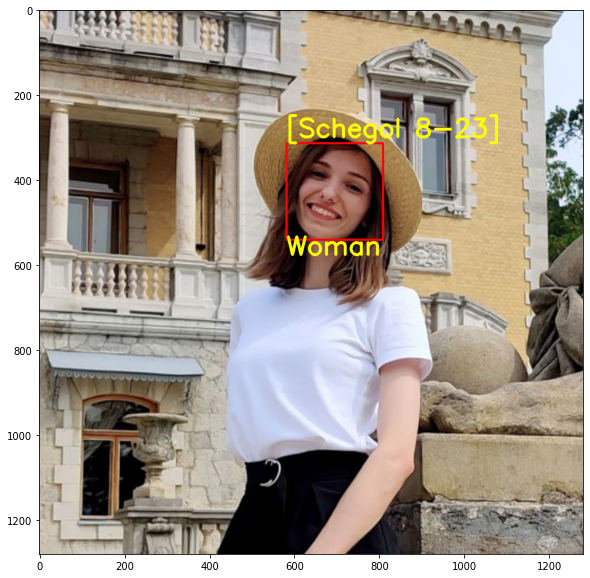

test_dataset/12.png
[[8.9857512e-04 2.7333033e-01 7.2250932e-01 3.2617580e-03]
 [7.9777246e-06 1.6766692e-04 9.9982256e-01 1.8396775e-06]]


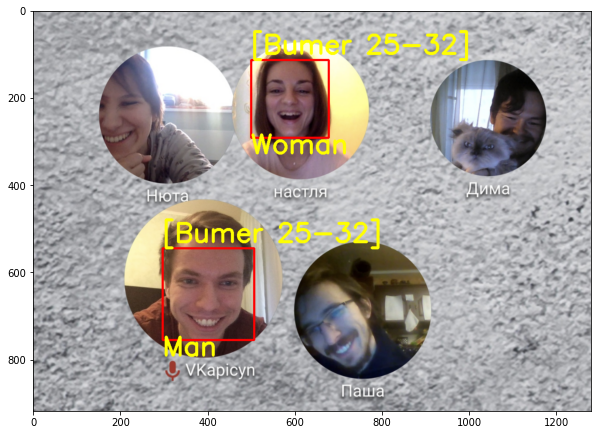

test_dataset/13.png
[[0.00581226 0.00402941 0.05590686 0.93425155]]


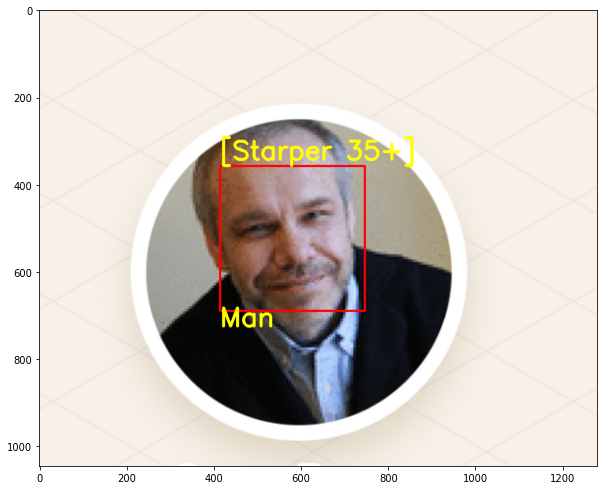

test_dataset/11.png
[[3.9368864e-05 1.5369256e-03 9.9827611e-01 1.4755322e-04]
 [4.0614482e-06 5.2238109e-05 9.9986267e-01 8.1047663e-05]
 [2.8061189e-05 5.4370158e-04 9.9913812e-01 2.9008731e-04]]


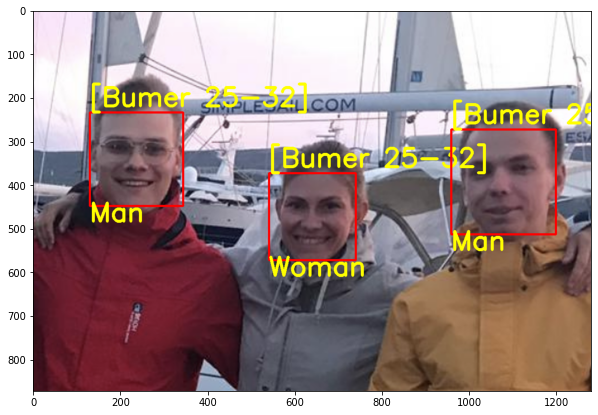

test_dataset/10.jpg
[[8.8389235e-05 8.8980893e-04 9.9347430e-01 5.5474592e-03]]


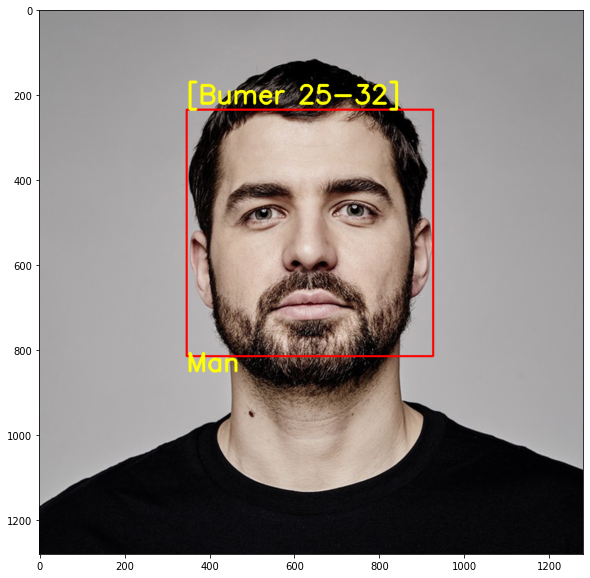

test_dataset/8.jpeg
[[0.03319191 0.39072406 0.25560448 0.3204796 ]
 [0.01567717 0.9658966  0.01674134 0.00168495]]


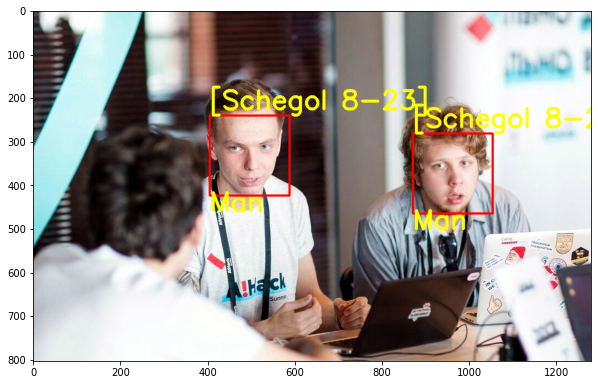

test_dataset/4.png
[[3.6489998e-04 2.7393894e-02 9.7212529e-01 1.1594186e-04]]


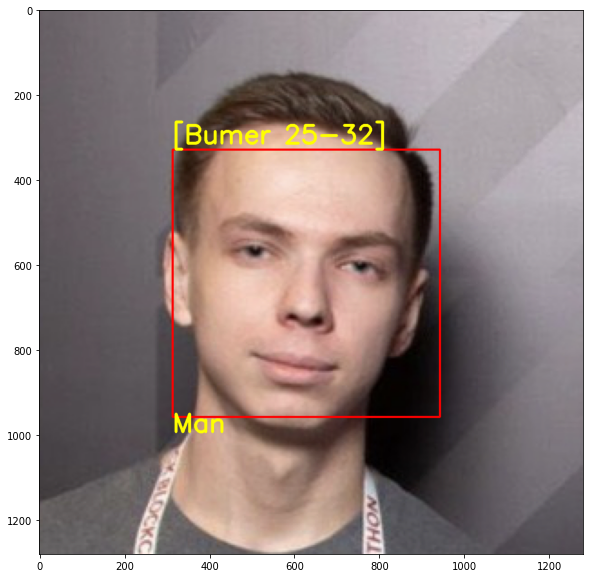

test_dataset/5.png
[[9.9569714e-01 3.6514010e-03 3.1133106e-05 6.2035292e-04]]


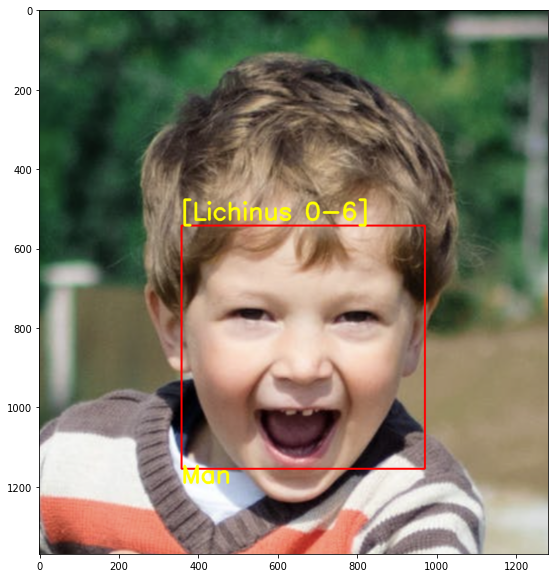

test_dataset/7.jpg
[[1.7455299e-05 1.8566703e-05 9.9984598e-01 1.1803679e-04]]


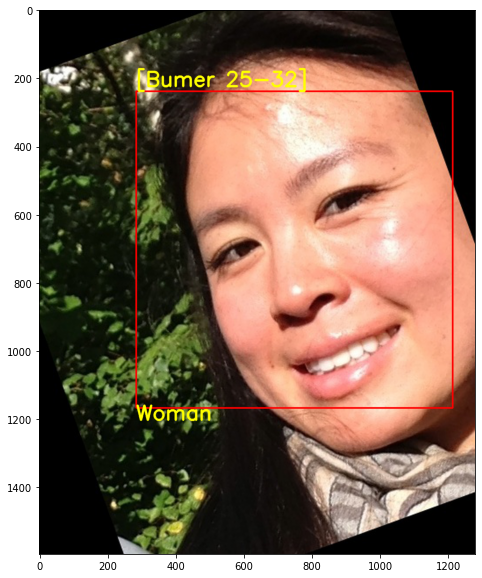

test_dataset/6.png
[[0.0114427  0.9494486  0.03692388 0.0021849 ]]


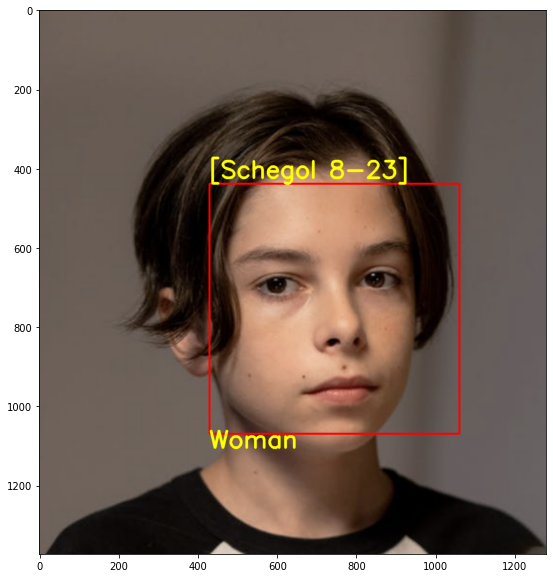

test_dataset/2.png
[[5.0810736e-04 1.8257944e-02 9.8041713e-01 8.1687357e-04]]


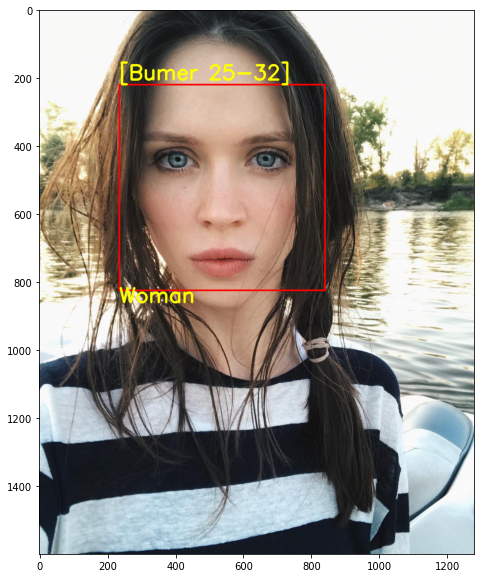

test_dataset/3.png
[[4.6881620e-04 2.8390773e-02 9.3005729e-01 4.1083038e-02]]


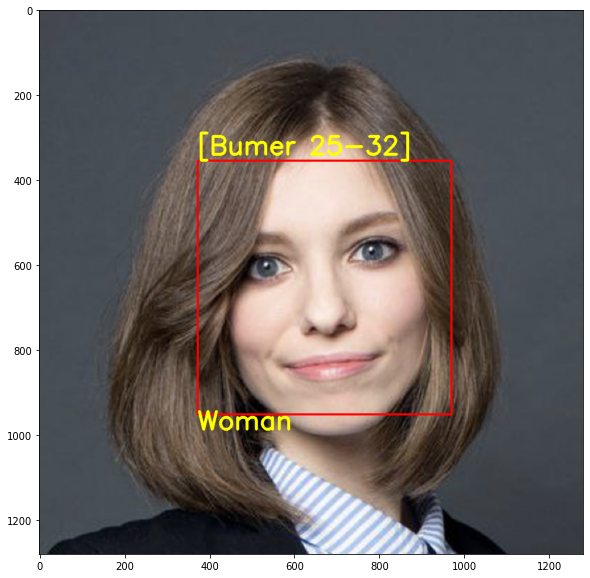

test_dataset/1.png
[[1.3777917e-03 1.0908651e-02 9.8703647e-01 6.7709584e-04]]


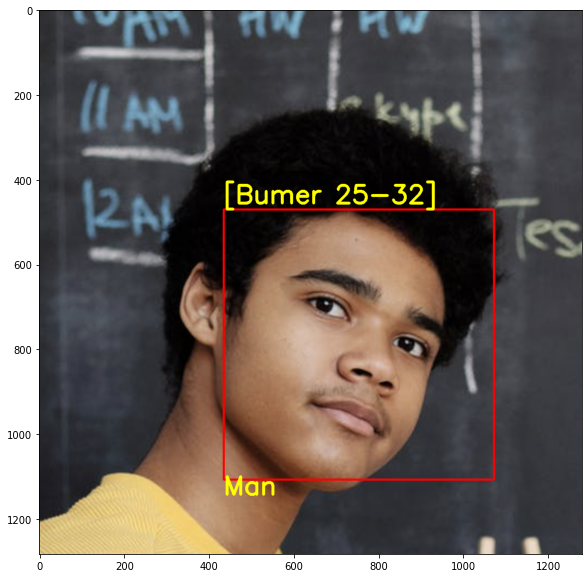

test_dataset/14
[[2.8625932e-03 8.6607202e-04 6.0942519e-02 9.3532884e-01]]


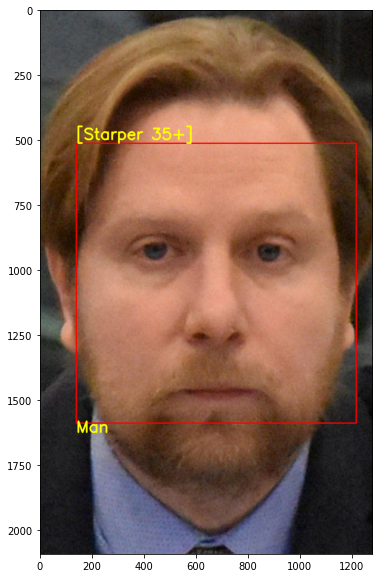

In [7]:
for image in images:
    print(image)
    target_image = image
    faces = crop_faces(target_image)
    if len(faces)>0:
        predict_gender = predict_gender_by_image(faces)
        predict_age = predict_age_by_image(faces)
        print(predict_age)
        sub_faces(target_image, predict_gender, predict_age)
    else:
        print("Лица не обнаружены")